In [1]:
#The demons algorithm proposed by J.P. Thirion to register two frames.
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import AxesGrid

Text(0.5, 1.0, 'STEM frame')

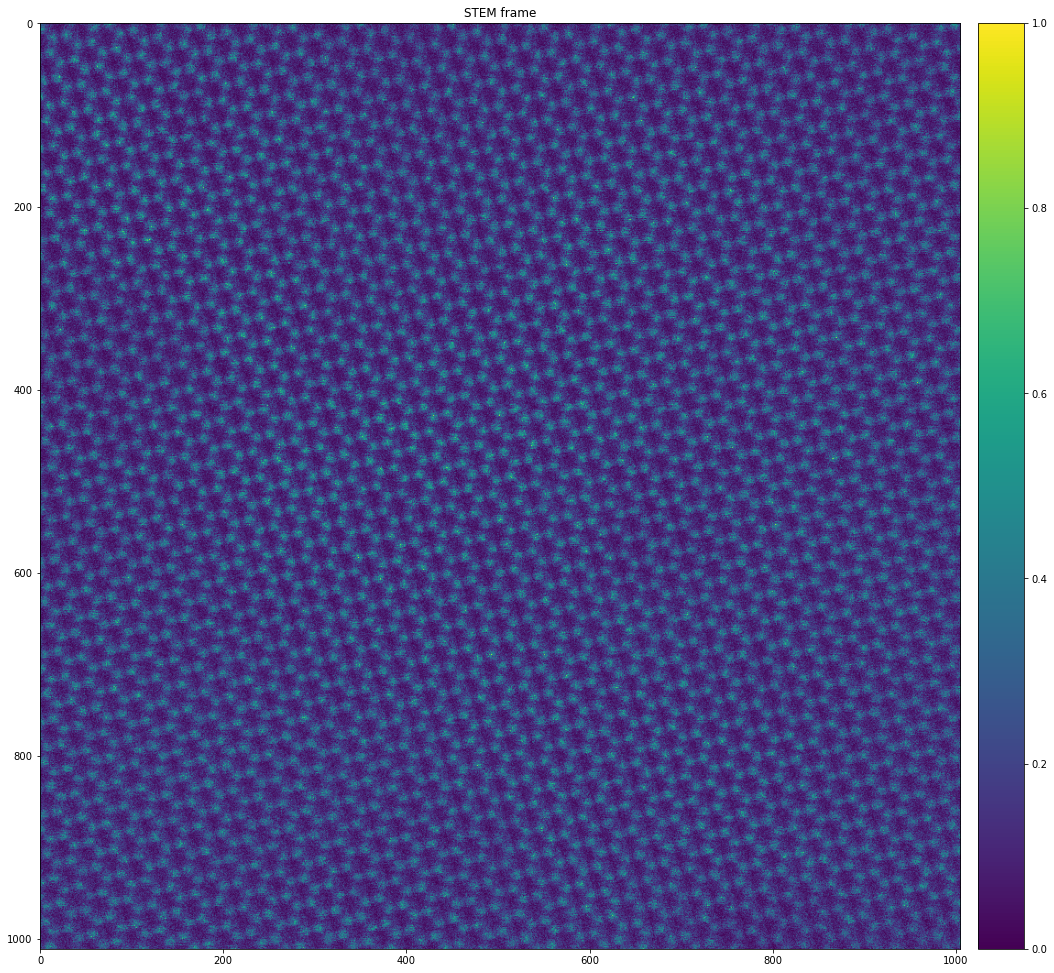

In [2]:
#simple test the demons algorithm by placing uniform-rigid shift.
em_data = np.load("orthogonal pairs/hori.npy")[0]
#plot the data.
fig =plt.figure(1, figsize=(60, 60))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(em_data[:, :], cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("STEM frame")

Text(0.5, 1.0, 'STEM frame')

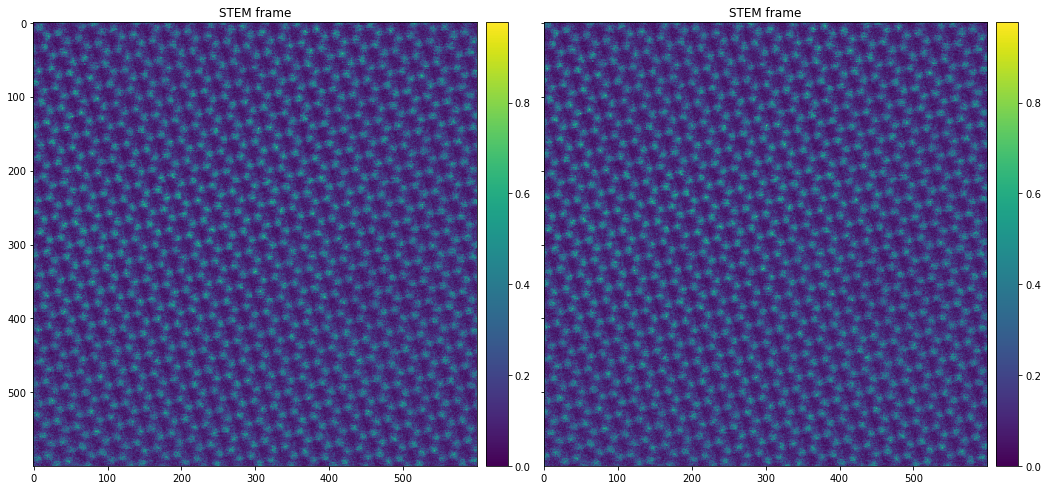

In [3]:
box = 300
middlex = int(em_data.shape[1]/2)
middley = int(em_data.shape[0]/2)
frame1 = em_data[(middley-box):(middley+box),(middlex-box):(middlex+box)].copy()
middlex += 4
middley += 4
frame2 = em_data[(middley-box):(middley+box),(middlex-box):(middlex+box)].copy()
#show the two frames.
fig =plt.figure(1, figsize=(60, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(frame1, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("STEM frame")
im=grid[1].imshow(frame2, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("STEM frame")

Text(0.5, 1.0, 'STEM frame')

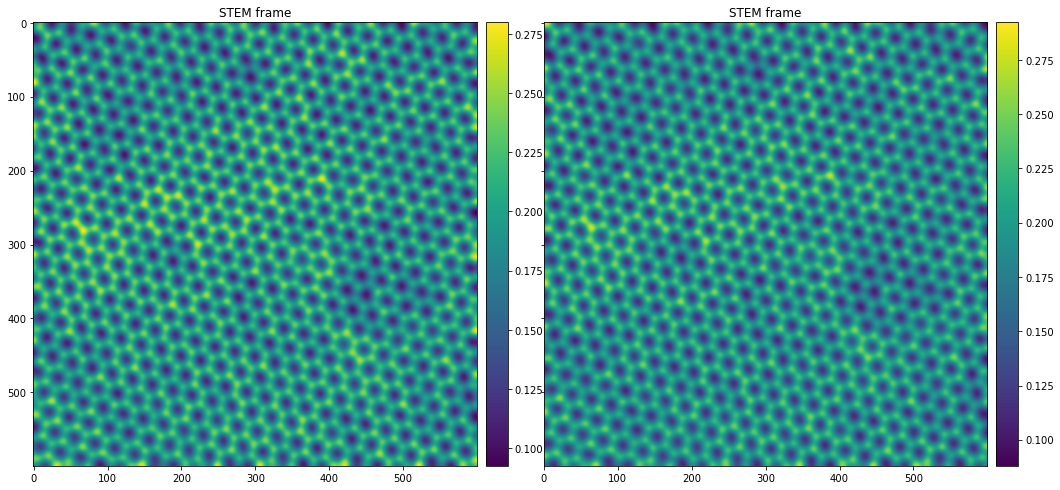

In [4]:
#blur the frame to ensure a smooth distribution of 
bframe1 = gaussian_filter(frame1, sigma=5)
bframe2 = gaussian_filter(frame2, sigma=5)
fig =plt.figure(1, figsize=(60, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(bframe1, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("STEM frame")
im=grid[1].imshow(bframe2, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("STEM frame")

In [5]:
#apply low-pass-filtering to the displacement field acquired at different iterations.
#generate the Gaussian shaped Fourier window. 
def GeneReciRadiusMap(frame):
    #consider the case where width and height have differences.
    #the interval along the horizontal direction and vertical direction is
    #the same, so the maximum frequency along vertical and horizontal direction is the same.
    min_len = np.min(frame.shape)
    x_coeff = min_len/frame.shape[0]
    y_coeff = min_len/frame.shape[1]
    #generate the normalized radius
    y, x = np.indices((frame.shape))
    centerx = np.round((frame.shape[1]+1)/2)
    centery = np.round((frame.shape[0]+1)/2)
    r = np.sqrt(((x - centerx)*x_coeff)**2 + ((y - centery)*y_coeff)**2)
    #the maximum radius along both direction is the minimum length of the frame.
    return r
def FFTWindow2D(frame, sigma):
    radius_map = GeneReciRadiusMap(frame)
    window2d = np.exp(-radius_map*radius_map/(sigma*sigma*2))
    return window2d
def LPF(frame, sigma_val):
    #apply FFT
    frame_fft = np.fft.fftshift(np.fft.fft2(frame))
    #generate radius map.
    radius_map = GeneReciRadiusMap(frame)
    #generate the weight matrix.
    weight = np.exp(-0.5*radius_map*radius_map/(sigma_val*sigma_val))
    #apply iFFT
    return np.fft.ifft2(np.fft.ifftshift(weight*frame_fft))
def HPF(r_map, sigma_val):
    #apply FFT
    frame_fft = np.fft.fftshift(np.fft.fft2(frame))
    #generate radius map.
    radius_map = GeneReciRadiusMap(frame)
    weight = 1.0-np.exp(-0.5*radius_map*radius_map/(sigma_val*sigma_val))
    #apply iFFT
    return np.fft.ifft2(np.fft.ifftshift(weight*frame_fft))
def RowConstraint(frame):
    #apply line constraint.
    row = int(frame.shape[0])
    col = int(frame.shape[1])
    constraint = np.zeros_like(frame)
    for i in range(row):
        constraint[i]= np.average(frame[i])
    return constraint
def ColConstraint(frame):
    row = int(frame.shape[0])
    col = int(frame.shape[1])
    constraint = np.zeros_like(frame)
    for i in range(col):
        constraint[:,i]= np.average(frame[:, i])
    return constraint

In [9]:
error_profile = []
#set the alpha coefficient.
alpha_coeff = 1.0
Y, X = np.indices(frame1.shape)
#generate the gradient of the reference frame
grady, gradx = np.gradient(bframe2)
grad_modu = gradx*gradx + grady*grady
#initialize the displacement field.
shiftx = np.zeros_like(bframe1)
shifty = np.zeros_like(bframe1)
#initialize the deformed frame.
deformed = bframe1.copy()
window2d = FFTWindow2D(frame1, frame1.shape[0]/2)
for i in range(100):
    difference = bframe2 - deformed
    #the displacement value of the border part of the deformed frame is set to zero.
    #these part the intensity is Nan after interpolation using the cubic interpolation method.
    difference[np.where(np.isnan(difference))] = 0.0
    error_profile.append(np.sum(np.abs(difference)))
    deform_coeff = difference/(grad_modu + alpha_coeff*np.square(difference))
    #compute the increase of the displacement field.
    dispx = deform_coeff*gradx
    dispy = deform_coeff*grady
    shiftx += RowConstraint(dispx)
    shifty += RowConstraint(dispy)
    #disp = dispx + 1j*dispy
    #apply the constraint to the shift vectors
    #filter_disp = LPF(disp, 3)
    #shiftx += np.real(filter_disp)
    #shifty += np.imag(filter_disp)
    #deform frame 1 using the computed displacement field.
    x = X + shiftx
    y = Y + shifty
    deformed = griddata((X.flatten(),Y.flatten()),bframe1.flatten(),(x.flatten(),y.flatten()), method='cubic')
    deformed = np.reshape(deformed, frame1.shape)

Text(0.5, 1.0, 'displacement windowed FFT')

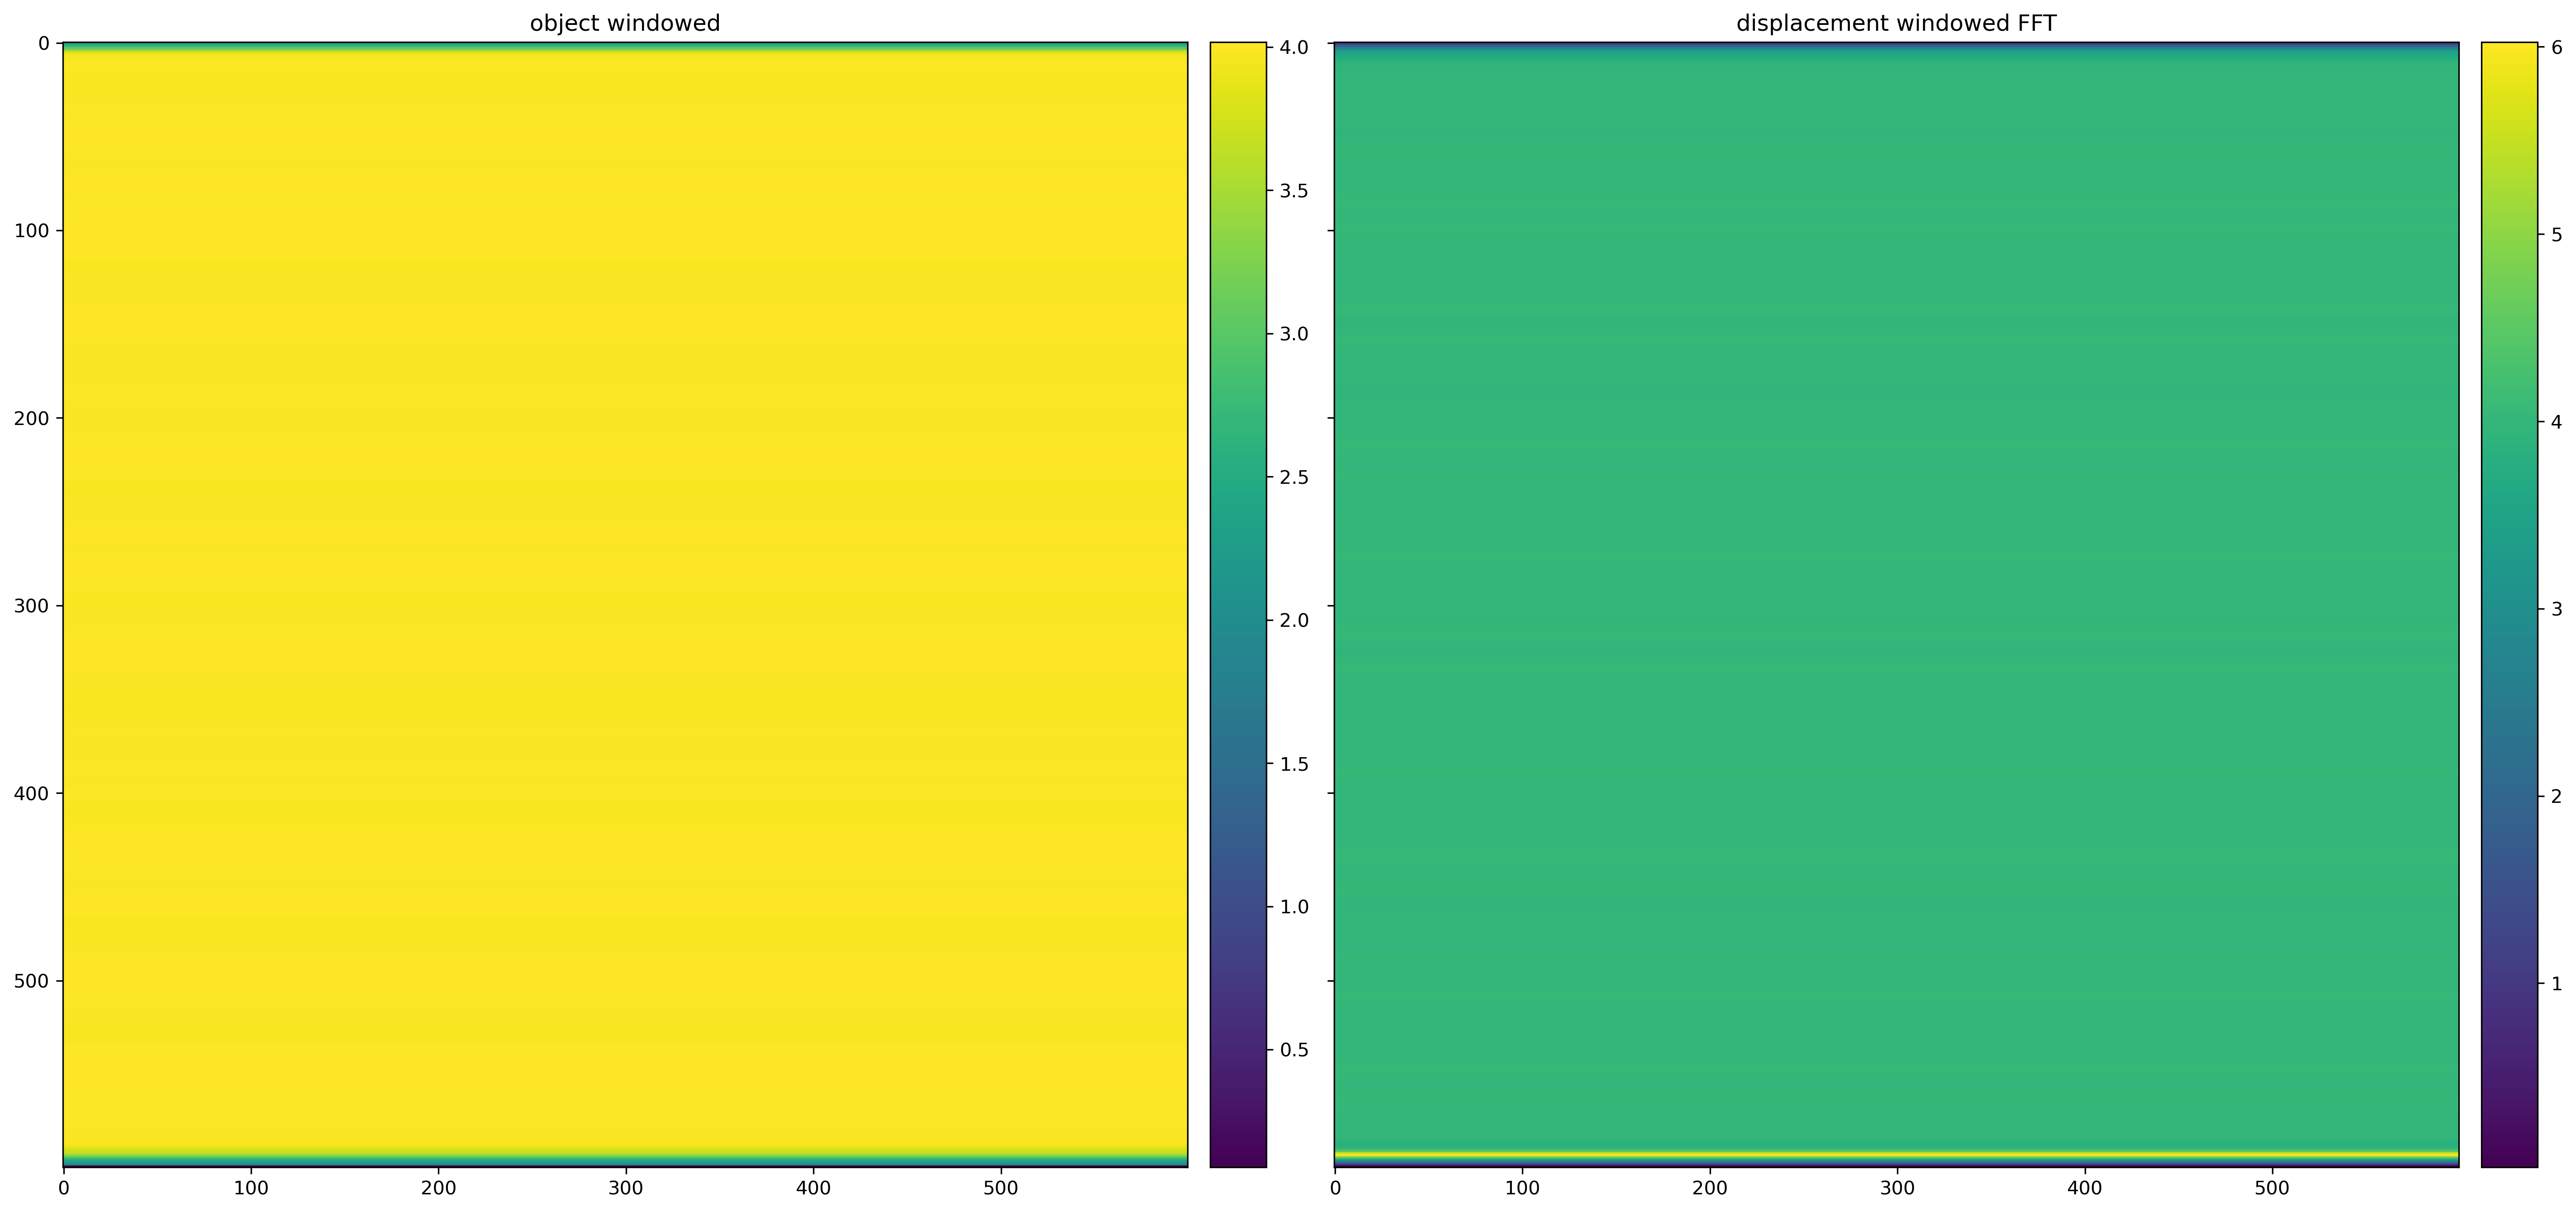

In [10]:
#print the determined displacement field
fig =plt.figure(1, figsize=(80, 80))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(shiftx, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("object windowed")
im=grid[1].imshow(shifty, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("displacement windowed FFT")

Text(0.5, 1.0, 'demons algorithm convergence curve')

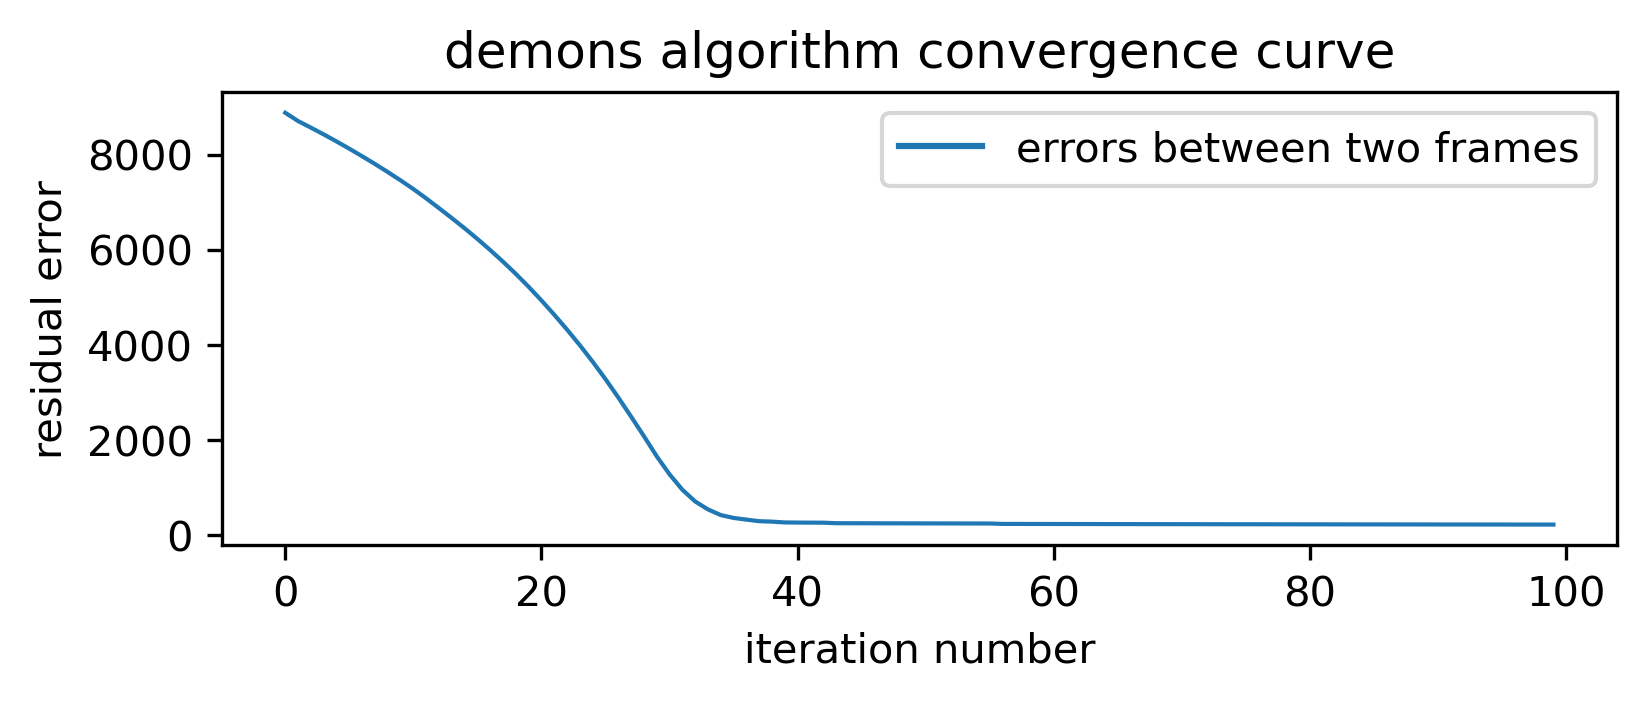

In [11]:
#plot the error profiles.
plt.rcParams['figure.figsize'] = (6.0, 2.0)
plt.rcParams['figure.dpi'] = 300
EM_data=np.column_stack((error_profile, ))
data = pd.DataFrame(EM_data, columns=["errors between two frames"])
plot= sns.lineplot(data=data, palette="tab10", linewidth=1.0)
plt.ylabel('residual error')
plt.xlabel('iteration number')
ticks = [0, 20, 40, 60, 80, 100]
plot.set_xticks(ticks)
txt_labels = ["0", "20", "40", "60", "80", "100"]
plot.set_xticklabels(txt_labels)
plot.set_title('demons algorithm convergence curve')